# Regression Exercise - Solution

Fit three `LinearRegressionWithSGD` model and three `RandomForest` model to the three dataset defined below.

## Loading all libraries

In [1]:
# import spark
from pyspark import SparkContext
# initialize a new Spark Context to use for the execution of the script
sc = SparkContext(appName="MY-APP-NAME", master="local[*]")
# prevent useless logging messages
sc.setLogLevel("ERROR")

In [2]:
import math
import numpy as np
import random
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Data Generation

In [4]:
def lin_formula(x):
    return -1.5 + x * 0.5
def sq_formula(x):
    return -1.5 + 0.5 * (x-(interval[1]-interval[0])/2.0) ** 2
def sin_formula(x):
    return -0.5 + np.sin(x/0.75)

In [5]:
number_points = 200
std_dev = 0.15
interval = (0, 5)

np.random.seed(0)
real_x = np.linspace(interval[0], interval[1], (interval[1]-interval[0])*100)
random_x = np.random.uniform(interval[0], interval[1], number_points)

In [6]:
def add_error(x, epsilon=0):
    return x + np.random.normal(0, epsilon, x.shape)

real_lin = lin_formula(real_x)
real_sq = sq_formula(real_x)
real_sin = sin_formula(real_x)

random_lin = add_error(lin_formula(random_x), std_dev)
random_sq = add_error(sq_formula(random_x), std_dev)
random_sin = add_error(sin_formula(random_x), std_dev)

## Visualization input data

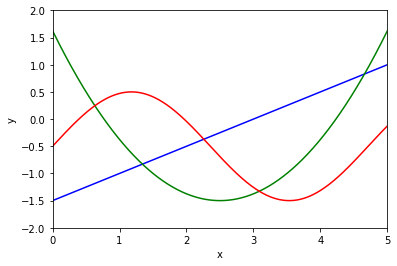

In [8]:
plt.plot(real_x, real_lin, c="b")
plt.plot(real_x, real_sq, c="g")
plt.plot(real_x, real_sin, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()

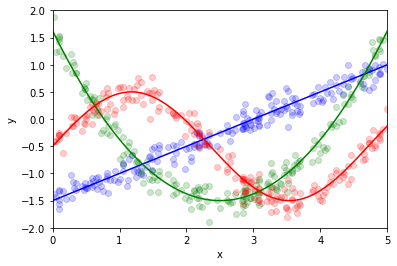

In [9]:
plt.scatter(random_x, random_lin, c="b", alpha=0.2)
plt.scatter(random_x, random_sq, c="g", alpha=0.2)
plt.scatter(random_x, random_sin, c="r", alpha=0.2)
plt.plot(real_x, real_lin, c="b", alpha=1)
plt.plot(real_x, real_sq, c="g", alpha=1)
plt.plot(real_x, real_sin, c="r", alpha=1)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()

## Training & Predict

In [10]:
rdd_real_x = sc.parallelize(real_x).map(lambda x: np.array([x]))

In [11]:
def transform_to_rdd(x,y):
    return sc.parallelize(np.column_stack((x, y))).map(lambda pair: LabeledPoint(pair[1], np.array([pair[0]])))

train_lin_rdd = transform_to_rdd(random_x, random_lin)
train_sq_rdd = transform_to_rdd(random_x, random_sq)
train_sin_rdd = transform_to_rdd(random_x, random_sin)

### LinearRegressionWithSGD

In [12]:
params = {
    "iterations": 100,
    "step": 1,
    "intercept": True
}
%time lin_model = LinearRegressionWithSGD.train(train_lin_rdd, **params)
%time sq_model = LinearRegressionWithSGD.train(train_sq_rdd, **params)
%time sin_model = LinearRegressionWithSGD.train(train_sin_rdd, **params)

CPU times: user 30 ms, sys: 7.7 ms, total: 37.7 ms
Wall time: 3.47 s
CPU times: user 21.6 ms, sys: 15.1 ms, total: 36.7 ms
Wall time: 1.25 s
CPU times: user 18.9 ms, sys: 16 ms, total: 34.9 ms
Wall time: 959 ms


Predict using the three models

In [15]:
pred_lin = lin_model.predict(rdd_real_x).collect()
pred_sq = sq_model.predict(rdd_real_x).collect()
pred_sin = sin_model.predict(rdd_real_x).collect()

Plot the predictions against the input points and the original distributions

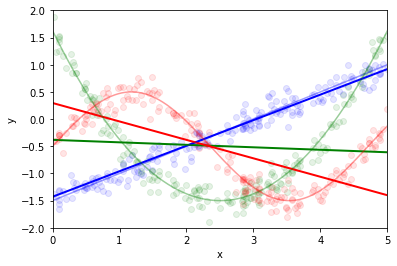

In [16]:
plt.plot(real_x, pred_lin, c="b", linewidth=2)
plt.plot(real_x, pred_sq, c="g", linewidth=2)
plt.plot(real_x, pred_sin, c="r", linewidth=2)
plt.scatter(random_x, random_lin, c="b", alpha=0.1)
plt.scatter(random_x, random_sq, c="g", alpha=0.1)
plt.scatter(random_x, random_sin, c="r", alpha=0.1)
plt.plot(real_x, real_lin, c="b", alpha=0.4)
plt.plot(real_x, real_sq, c="g", alpha=0.4)
plt.plot(real_x, real_sin, c="r", alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()

# Random Forest

In [17]:
params = {
    "categoricalFeaturesInfo":{},
    "numTrees":50,
    "featureSubsetStrategy":"auto",
    "maxDepth":8,
    "maxBins":64
}
%time lin_model = RandomForest.trainRegressor(train_lin_rdd, **params)
%time sq_model = RandomForest.trainRegressor(train_sq_rdd, **params)
%time sin_model = RandomForest.trainRegressor(train_sin_rdd, **params)

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 2.22 s
CPU times: user 11.1 ms, sys: 474 µs, total: 11.6 ms
Wall time: 1.02 s
CPU times: user 5.85 ms, sys: 4.51 ms, total: 10.4 ms
Wall time: 878 ms


Predict using the three models

In [18]:
pred_lin = lin_model.predict(rdd_real_x).collect()
pred_sq = sq_model.predict(rdd_real_x).collect()
pred_sin = sin_model.predict(rdd_real_x).collect()

Plot the predictions against the input points and the original distributions

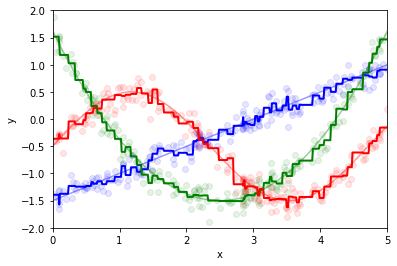

In [20]:
plt.plot(real_x, pred_lin, c="b", linewidth=2)
plt.plot(real_x, pred_sq, c="g", linewidth=2)
plt.plot(real_x, pred_sin, c="r", linewidth=2)
plt.scatter(random_x, random_lin, c="b", alpha=0.1)
plt.scatter(random_x, random_sq, c="g", alpha=0.1)
plt.scatter(random_x, random_sin, c="r", alpha=0.1)
plt.plot(real_x, real_lin, c="b", alpha=0.4)
plt.plot(real_x, real_sq, c="g", alpha=0.4)
plt.plot(real_x, real_sin, c="r", alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()